In [1]:
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# import model from the kuangliu repo 
from resnet import ResNet18

In [3]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network.
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

### The data from CIFAR10 are already downloaded in the following folder
rootdir = '/opt/img/effdl-cifar10/'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

trainloader = DataLoader(c10train,batch_size=32,shuffle=True)
testloader = DataLoader(c10test,batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 15000

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647

## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")

# Finally we can define anoter dataloader for the training data
trainloader_subset = DataLoader(c10train_subset,batch_size=32,shuffle=True)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.

Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 15000 samples


## TASK 1. Train a model from scratch

In [5]:
# device conf : using GPU if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# define the model used
model = ResNet18()
model = model.to(device)

In [7]:
# hyperparameters
num_epochs = 10
learning_rate = 0.001
is_scheduler = True

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define a schedule which gonna divide the lr by 10 when reaching a plateau in performance for the accuracy
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

/opt/img/effdl-venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# use a scheduler to change the learning rate
# import librairies

In [ ]:
def train_model(model, trainloader, testloader, epochs, is_scheduler):
    train_accuracy_list, test_accuracy_list = [], []
    train_loss_list, test_loss_list = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Training accuracy
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(running_loss / len(trainloader))

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * (correct_test / total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss / len(testloader))

        # if using a scheduler
        if is_scheduler:
            scheduler.step(test_loss / len(testloader))

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {running_loss/len(trainloader):.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Test Acc: {test_accuracy:.2f}% ",
              f"Learning Rate: {optimizer.param_groups[0]['lr']}")

    print("Training complete my boss")

    ############# PLOT THE LOSS AND THE ACCURACY PER EPOCH ####################
    epochs = range(1, num_epochs+1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
    
    # Loss plot
    axes[0].plot(epochs, train_loss_list, label="Training loss", color="blue")
    axes[0].plot(epochs, test_loss_list, label="Testing loss", color="red")
    axes[0].set_title("Training and testing loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Accuracy plot
    axes[1].plot(epochs, train_accuracy_list, label="Training accuracy", color="blue")
    axes[1].plot(epochs, test_accuracy_list, label="Testing accuracy", color="red")
    axes[1].set_title("Training and Testing accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()
    
    plt.tight_layout() 
    plt.show()
    #return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list 

Epoch 1: Train Loss: 1.5147, Train Acc: 44.12%, Test Acc: 57.20%  Learning Rate: 0.001
Epoch 2: Train Loss: 1.0276, Train Acc: 63.27%, Test Acc: 68.89%  Learning Rate: 0.001
Epoch 3: Train Loss: 0.8100, Train Acc: 71.49%, Test Acc: 73.85%  Learning Rate: 0.001
Epoch 4: Train Loss: 0.6645, Train Acc: 76.78%, Test Acc: 79.23%  Learning Rate: 0.001
Epoch 5: Train Loss: 0.5661, Train Acc: 80.31%, Test Acc: 80.44%  Learning Rate: 0.001
Epoch 6: Train Loss: 0.5022, Train Acc: 82.51%, Test Acc: 82.75%  Learning Rate: 0.001
Epoch 7: Train Loss: 0.4450, Train Acc: 84.58%, Test Acc: 81.92%  Learning Rate: 0.001
Epoch 8: Train Loss: 0.4008, Train Acc: 86.19%, Test Acc: 86.08%  Learning Rate: 0.001
Epoch 9: Train Loss: 0.3635, Train Acc: 87.56%, Test Acc: 84.99%  Learning Rate: 0.001
Epoch 10: Train Loss: 0.3310, Train Acc: 88.51%, Test Acc: 86.95%  Learning Rate: 0.001
Training complete my boss


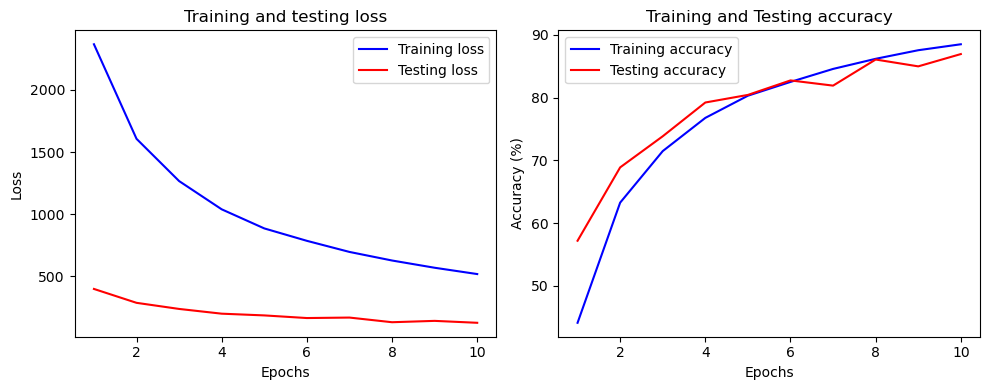

In [11]:
# Train the model
train_model(model, trainloader, testloader, epochs=num_epochs, is_scheduler=is_scheduler)

In [12]:
# # Save the model
# check_point = {
#     "epoch": num_epochs,
#     "model_state": model.state_dict(),
#     "optimizer": "Adam",
#     "optim_state": optimizer.state_dict() ,
#     "is_scheduler": is_scheduler
# }
# if check_point["is_scheduler"]:
#     check_point["scheduler"]=scheduler
    
# torch.save(check_point, './model_state/resnet18_model_simple.pth')

In [13]:
# # We load the dictionary
# loaded_cpt = torch.load('./model_state/resnet18_model_simple.pth')

# new_model = ResNet18()
# new_model.load_state_dict(loaded_cpt['model_state'])